#### Dataset for this problem can be downloaded from https://drive.google.com/file/d/1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC/view?usp=sharing

Acknowledgement

Chen, Pingjun (2018), “Knee Osteoarthritis Severity Grading Dataset”, Mendeley Data, V1, doi: 10.17632/56rmx5bjcr.1

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings;
warnings.filterwarnings('ignore');

### Read the labels of Images

In [3]:
data = pd.read_csv("/kaggle/input/kneexray/KneeXray/Train.csv")
test = pd.read_csv("/kaggle/input/kneexray/KneeXray/Test.csv")

In [4]:
data.head()
print(data.shape)

(7828, 2)


### Import necessary libraries

In [5]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten,Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In [6]:
datagen = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True, samplewise_std_normalization=True)

In [7]:
# Function to create a flow of images ,during training, using image name with respective labels present in dataframe.
def image_gen(train, valid):
    train_gen = datagen.flow_from_dataframe(dataframe=train,
                                            x_col="filename",
                                            y_col="label",
                                            directory="/kaggle/input/kneexray/KneeXray/train",
                                            class_mode="raw",
                                            target_size=(224, 224),
                                            shuffle=True,
                                            batch_size=64,
                                            sheer_range=0.2,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            zoom_range=0.4,
                                            brightness_range=[0.5, 1.8]
                                            )
    valid_gen = datagen.flow_from_dataframe(dataframe=valid,
                                            x_col="filename",
                                            y_col="label",
                                            directory="/kaggle/input/kneexray/KneeXray/train",
                                            class_mode="raw",
                                            target_size=(224, 224),
                                            shuffle=False,
                                            batch_size=64,
                                            )
    
    return train_gen, valid_gen
    

In [8]:
# Separate 'filename' and 'label'
X, y = data['filename'], data['label']

In [9]:
# Splitting X, y into train and validation set
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.05, stratify=y, random_state=2021)

In [10]:
train = pd.concat([train_X, train_y], axis=1)
valid = pd.concat([val_X, val_y], axis=1)

# Use 'image_gen' function to prepare train and validation data
train_gen, valid_gen = image_gen(train, valid)

Found 7436 validated image filenames.
Found 392 validated image filenames.


### Transfer Learning (VGG16-Pretrained Model)

In [11]:
# Using our own input shape whereas weights are pretrained on 'imagenet' data
model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Including all the layers of VGG16 except last layer
x = model.layers[-1].output

58892288/58889256 [==============================] - 1s 0us/step


In [12]:
#x = Conv2D(64, (4, 4), activation="relu")(m)
#x = MaxPooling2D((3, 3))(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)

#x = Conv2D(32, (4, 4), activation="relu")(m)
#x = MaxPooling2D((3, 3))(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)

#x = Conv2D(64, (4, 4), activation="relu")(m)
#x = MaxPooling2D((3, 3))(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)




# Flatten previous layers
x = Flatten()(x)

# Output layer having 5 classes
out = Dense(5, activation="softmax")(x)

# Final model to train using a pretrained layers
new_model = Model(inputs=model.input, outputs=out)





#for layer in new_model.layers[:-5]:
 #   layer.trainable=False

In [13]:
# Setting optimizer 
opt = optimizers.Adam(learning_rate=0.0001)

# Callbacks to allow certain restrictions during training 
callback = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), ModelCheckpoint(filepath="/kaggle/working", monitor='val_loss', save_best_only=True)]

# Set loss function, optimizer and chosen metric 
new_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

### Model training

In [14]:
# Fitting our model on training images
history = new_model.fit(train_gen,  validation_data=valid_gen, epochs=25, callbacks=callback)#, class_weight={0:0.1, 2:0.4, 1:0.6, 3:0.8, 4:5})

Epoch 1/25
117/117 [==============================] - 86s 622ms/step - loss: 1.4136 - accuracy: 0.3832 - val_loss: 1.2995 - val_accuracy: 0.4490
Epoch 2/25
117/117 [==============================] - 47s 400ms/step - loss: 1.1366 - accuracy: 0.5174 - val_loss: 0.9827 - val_accuracy: 0.5765
Epoch 3/25
117/117 [==============================] - 48s 405ms/step - loss: 0.8815 - accuracy: 0.6254 - val_loss: 0.8867 - val_accuracy: 0.6224
Epoch 4/25
117/117 [==============================] - 48s 405ms/step - loss: 0.7705 - accuracy: 0.6733 - val_loss: 0.7545 - val_accuracy: 0.6939
Epoch 5/25
117/117 [==============================] - 47s 408ms/step - loss: 0.7219 - accuracy: 0.7011 - val_loss: 0.7736 - val_accuracy: 0.6735
Epoch 6/25
117/117 [==============================] - 47s 405ms/step - loss: 0.6271 - accuracy: 0.7385 - val_loss: 0.7819 - val_accuracy: 0.6735
Epoch 7/25
117/117 [==============================] - 47s 404ms/step - loss: 0.5826 - accuracy: 0.7604 - val_loss: 0.8109 - val_ac

### Save our trained model

In [15]:
new_model.save('model.h5')

### Predict on Validation Data

In [26]:
valid_pred = np.argmax(new_model.predict(valid_gen), axis=1)

### Plotting Accuracy and Loss of our model w.r.t number of Epochs the model is trained on

In [28]:
import matplotlib.pyplot as plt

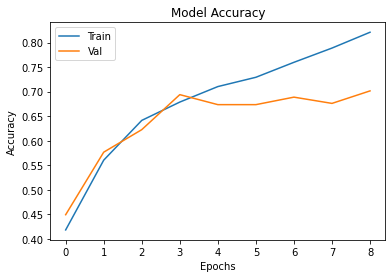

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

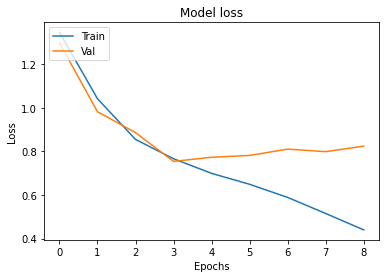

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Classification Report on metrics like F1 Score, Precision, Recall

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [33]:
report = classification_report(np.array(valid['label']), valid_pred)

In [34]:
print(report)

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       154
           1       0.37      0.10      0.16        71
           2       0.67      0.67      0.67       103
           3       0.75      0.87      0.80        52
           4       1.00      0.67      0.80        12

    accuracy                           0.69       392
   macro avg       0.70      0.65      0.65       392
weighted avg       0.65      0.69      0.65       392



### From above we can see, F1 Score on our Validation(untrained) data is around 0.65

In [35]:
valid['label'].unique()

array([2, 3, 0, 1, 4])

### Model Summary(Different Layers)

In [37]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [38]:
# Tensorflow Version
tf.__version__

'2.4.1'

In [39]:
valid.head()

,filename,label
5072,Image_5073.jpg,2
1456,Image_1457.jpg,2
7357,Image_7358.jpg,2
4270,Image_4271.jpg,3
6740,Image_6741.jpg,0
